In [1]:
#using TaylorSeries
include("UndrivenHelium.jl")
#include("Integ.jl")
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false, size=(600,600), color=:black, markersize = 0.3 )
const Z = 2.0
const order = 20
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500_000

500000

  3.544902 seconds (24.65 M allocations: 1.317 GiB, 14.60% gc time)



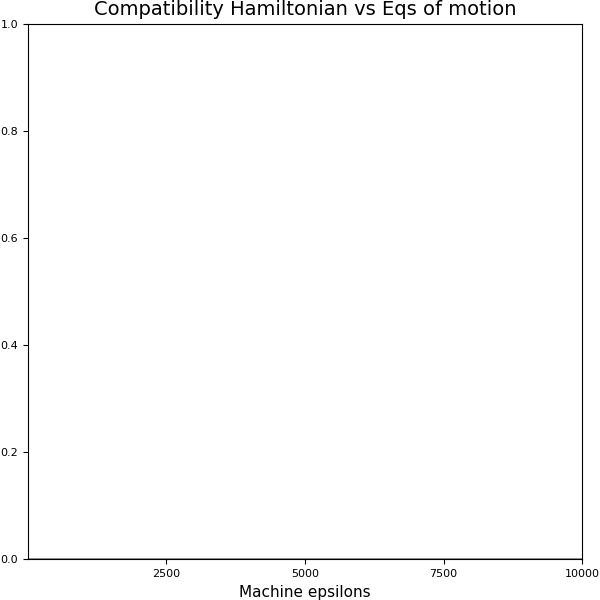

In [2]:
@time dnorm, als= errHam1D(10_000);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")
xaxis!("Machine epsilons")

In [3]:
include("Integ.jl")

taylorintegps (generic function with 1 method)

In [4]:
c1 = condini1D(2.0, 0.0)

4-element Array{Float64,1}:
 1.41421
 0.0    
 0.0    
 4.0    

In [5]:
t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 15.0, order, abs_tol, maxsteps=100);

  0.306686 seconds (259.04 k allocations: 20.226 MiB, 3.35% gc time)


In [6]:
t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 15.0, order, abs_tol, maxsteps=100);

  0.018654 seconds (185.52 k allocations: 15.739 MiB, 47.10% gc time)


In [7]:
length(t1), length(t2)

(101, 100)

In [8]:
ene1 = zeros(t1)
ene2 = zeros(t2)
for j in eachindex(ene1)
    ene1[j] = abs(regHam1D(x1[j,:]))/eps()
end
for j in eachindex(ene2)
    ene2[j] = abs(regHam1D(x2[j,:]))/eps()
end

In [13]:
ene1

101-element Array{Float64,1}:
  0.0    
  2.21875
  2.0    
  0.5    
  1.0    
  2.0    
  2.0    
  1.0    
  0.0    
  2.0    
  6.0    
  6.0    
  4.0    
  ⋮      
 10.0    
 18.0    
 10.875  
  6.5    
 19.0    
 22.0    
 12.0    
 16.0    
 16.0    
  8.0    
  8.0    
  0.0    


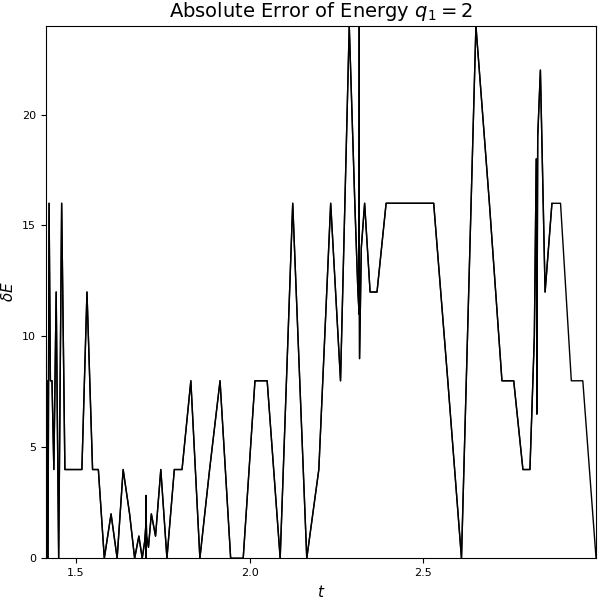

In [14]:
plot(x1[:,1], ene1, title =L"Absolute Error of Energy $q_1=2$")
plot!(x2[:,1], ene2, title =L"Absolute Error of Energy $q_1=2$")
xaxis!(L"t")
yaxis!(L"\delta E")



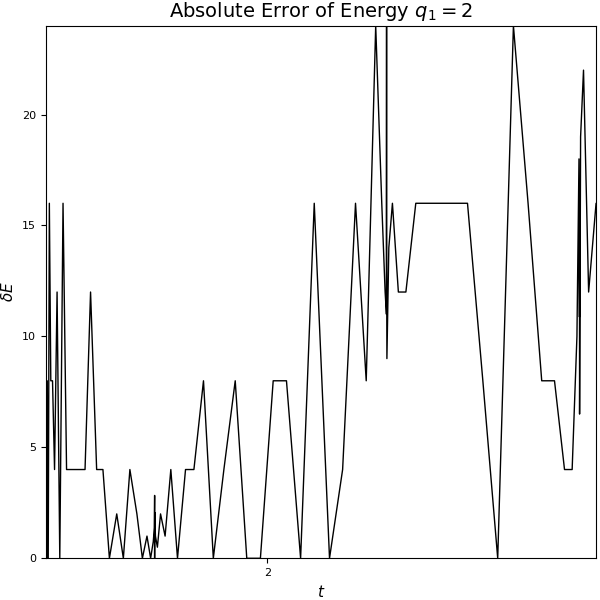

In [15]:
plot(x2[:,1], ene2, title =L"Absolute Error of Energy $q_1=2$")
xlabel!(L"t")
ylabel!(L"\delta E")

In [16]:
maximum(ene1)

24.0

In [126]:
function psundriven(x10::Float64, px10::Float64, tol::Float64 = 1e-20; tmax = 100.0, maxsteps1 = 5_000 )
    c1 = condini1D(x10, px10)
    t, x = taylorintegps(undrivenHelium1D!, c1, t0, tmax, order, abs_tol; maxsteps = maxsteps)
    ps = zeros(x)
    ts = zeros(t)
    count = 0
    for j in eachindex(ts)
        if abs(x[j,2]) < tol
            count += 1
            ts[count] = t[j]
            ps[count, :] = x[j, :]
        end
    end
    return ps[1:count, :], t, x
end

psundriven (generic function with 3 methods)

In [91]:
#Haremos malavares con metaprogramming para ver varias órbitas
nombret(n::Int) = Symbol( string("t", n) )
nombreps(n::Int) = Symbol( string("ps", n) )
nombreq(n::Int) = Symbol( string("q", n) )
nombrexs(n::Int) = Symbol( string("xs", n) )
nombrevxs(n::Int) = Symbol( string("vxs", n) )
nombreys(n::Int) = Symbol( string("ys", n) )
nombrevys(n::Int) = Symbol( string("vys", n) )

function orbits(nmin, rs = 2:10)
    N = length(rs)
    # Checo que `n` sea >= 1
    @assert N >= 0  

    for j = nmin:(N+nmin - 1)
        ex1 = quote 
            $(nombreps(j)), $(nombret(j)), $(nombreq(j))  = 
                psundriven(Float64($(rs[j])), 0.0)
             end
        ex2 = quote 
            $(nombrexs(j)) = map(ks, $(nombreps(j))[:,1])
             end
        
        ex3 = quote 
                 $(nombrevxs(j)) =  
            Float64[ksv($(nombreps(j))[k,1], $(nombreps(j))[k, 3]) 
                 for k in eachindex($(nombreps(j))[:, 1])]
             end
        ex4 = quote 
            $(nombreys(j)) = map(ks, $(nombreps(j))[:,2])
             end
        
        ex5 = quote 
            $(nombrevys(j)) =  
            Float64[ksv($(nombreq(j))[k,2], $(nombreps(j))[k, 4]) 
                for k in eachindex($(nombreps(j))[:,1])]
             end
        eval(ex1)
        eval(ex2)
        eval(ex3)
        eval(ex4)
        eval(ex5)
    end
end

function plottingps(nmax,xmin::Float64=0.0, xmax::Float64=20.0, 
    ymin::Float64=-1.0, ymax::Float64=1.0)
    scatter(xs1, vxs1, label = L"q = 2", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$")
    for j in 2:nmax
        ex = quote
            scatter!($(nombrexs(j)), $(nombrevxs(j)))
        end
        eval(ex)
    end
    xaxis!([0,20])
    xlabel!(L"x")
    ylabel!(L"p_x")
    yaxis!([ymin, ymax])
    xaxis!([xmin, xmax])
end

function ksv(Q, P)
    v₁ = P/2Q
    return v₁
end
ks(Q) = Q^2

ks (generic function with 1 method)

In [92]:
@time orbits(1,2:0.1:10)
NM = length(2:0.1:10)

 58.153922 seconds (615.46 M allocations: 50.253 GiB, 30.83% gc time)


81

  0.095488 seconds (140.22 k allocations: 6.332 MiB)



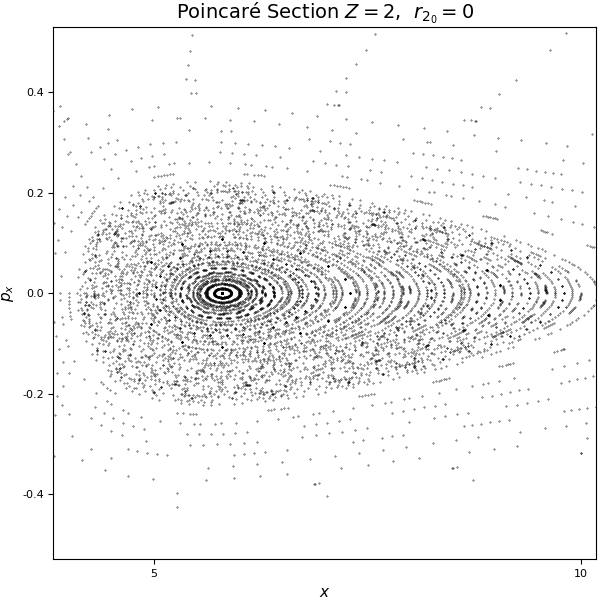

In [95]:
@time plottingps(NM, 4.0, 10., -.5, .5)
#@time plottingps(NM, 0., 4., -0.5, 0.5)

  0.098512 seconds (140.22 k allocations: 6.332 MiB)



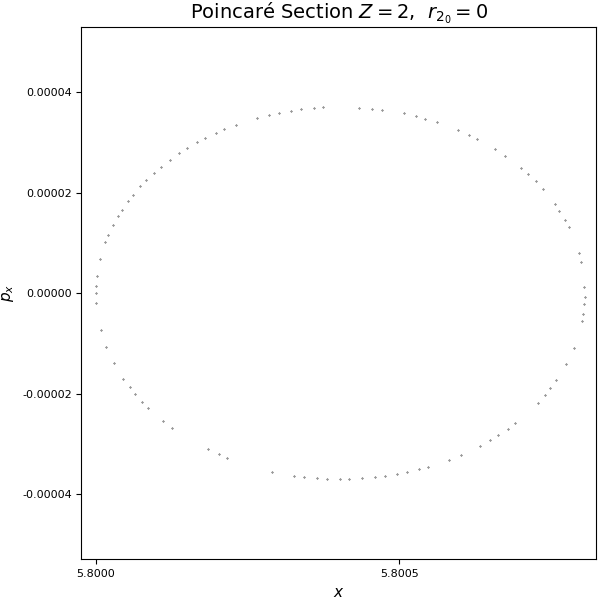

In [97]:
@time plottingps(NM, 5.8, 5.8008, -0.00005, 0.00005)

In [128]:
@time pd, td, xd = psundriven(5.8004, 0.0; tmax = 2_000.0, maxsteps1 = 10_000)

LoadError: [91mUndefVarError: maxsteps not defined[39m

In [120]:
length(td), length(pd)

(5000, 500)


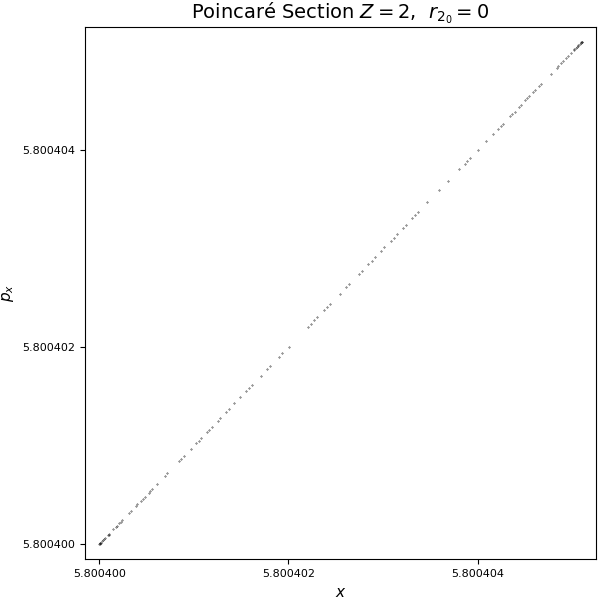

In [116]:
psdx = map(ks, pd[:,1])
ll = length(psdx)
psdvx = Float64[ksv(pd[j,1],pd[j,3]) for j in 1:ll]
scatter(psdx, psdx, label = L"q = 5.80004", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$")
xlabel!(L"x")
ylabel!(L"p_x")

In [81]:
xd

3607×4 SubArray{Float64,2,Array{Float64,2},Tuple{UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}:
 2.4084    0.0           0.0          4.0     
 2.4084    0.276734     -0.00100473   3.93593 
 2.4084    0.495479     -0.00567261   3.78941 
 2.40836   0.689528     -0.0148716    3.57681 
 2.40825   0.863033     -0.0279425    3.30414 
 2.40802   1.00219      -0.0413583    3.00999 
 2.40757   1.13473      -0.0549199    2.6397  
 2.40702   1.22865      -0.0627844    2.29614 
 2.4063    1.31254      -0.0653877    1.89441 
 2.40562   1.37076      -0.0614352    1.52168 
 2.40498   1.41527      -0.0513348    1.13045 
 2.40448   1.44532      -0.0361979    0.736968
 2.40417   1.46206      -0.0178561    0.348097
 ⋮                                            
 2.4084   -0.20179       0.000389691  3.96611 
 2.4084    2.77556e-17  -1.08455e-6   4.0     
 2.4084    0.0319807    -2.64536e-6   3.99915 
 2.4084    0.296195     -0.0012318    3.92649 
 2.4084    0.512382     -0.00626283   3.77421 
 2